In [1]:
# Install necessary libraries if not already installed
!pip install pandas numpy scikit-learn nltk matplotlib seaborn spacy wordcloud


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
mltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /home/flix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/flix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the dataset
try:
    df = pd.read_csv('resume.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Error: resume.csv not found. Please ensure the file exists in the current directory.")

Dataset loaded successfully!
Shape: (2484, 4)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [6]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub(r'httpS+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)    # remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', '', text) # remove special chars
    text = re.sub(r'\s+', ' ', text).strip() # remove extra whitespace
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)


In [11]:
# Apply cleaning
if 'Resume_str' in df.columns:
    df['cleaned_resume'] = df['Resume_str'].apply(clean_text)
elif 'Resume' in df.columns:
    df['cleaned_resume'] = df['Resume'].apply(clean_text)
else:
    # Fallback to the first column if exact name is unknown
    print("Column 'Resume_str' or 'Resume' not found. Using the first column as resume text.")
    df['cleaned_resume'] = df.iloc[:, 0].apply(clean_text)

print("Preprocessing completed.")
display(df[['cleaned_resume']].head())

Preprocessing completed.


,cleaned_resume
0,hr administratormarketing associate hr adminis...
1,hr specialist us hr operations summary versati...
2,hr director summary 20 years experience recrui...
3,hr specialist summary dedicated driven dynamic...
4,hr manager skill highlights hr skills hr depar...


In [13]:
# Combine JD with Resumes for Vectorization
all_docs = [cleaned_jd] + df['cleaned_resume'].tolist()

# Vectorize
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_docs)

# Calculate Cosine Similarity
# The first vector (index 0) is the Job Description
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

# Add scores to DataFrame
df['similarity_score'] = cosine_sim[0]

# Rank candidates
ranked_df = df.sort_values(by='similarity_score', ascending=False)
display(ranked_df[['Category', 'similarity_score']].head(10))

,Category,similarity_score
1218,CONSULTANT,0.319175
1762,ENGINEERING,0.300208
926,AGRICULTURE,0.253705
2153,BANKING,0.210633
1339,AUTOMOBILE,0.192728
2291,ARTS,0.192391
929,AGRICULTURE,0.162992
1142,CONSULTANT,0.162708
1348,AUTOMOBILE,0.162081
1303,DIGITAL-MEDIA,0.161552


In [14]:
# Define a simple skill dictionary (expand as needed)
tech_skills = ['python', 'java', 'c++', 'sql', 'machine learning', 'deep learning', 'nlp',
               'pandas', 'numpy', 'scikit-learn', 'tensorflow', 'keras', 'pytorch', 'tableau', 'power bi']

def extract_skills(text, skill_list):
    found_skills = []
    for skill in skill_list:
        if skill in text:
            found_skills.append(skill)
    return found_skills

df['extracted_skills'] = df['cleaned_resume'].apply(lambda x: extract_skills(x, tech_skills))
display(df[['extracted_skills']].head())

,extracted_skills
0,[]
1,[]
2,[]
3,[]
4,[]


In [15]:
jd_skills = extract_skills(cleaned_jd, tech_skills)

def find_missing_skills(resume_skills, required_skills):
    return [skill for skill in required_skills if skill not in resume_skills]

df['missing_skills'] = df['extracted_skills'].apply(lambda x: find_missing_skills(x, jd_skills))

# Display Top 5 Candidates with details
top_candidates = df.sort_values(by='similarity_score', ascending=False).head(5)
print(f"Required Skills: {jd_skills}")
display(top_candidates[['Category', 'similarity_score', 'extracted_skills', 'missing_skills']])

Required Skills: ['python', 'sql', 'machine learning', 'deep learning', 'nlp', 'pandas', 'numpy', 'tensorflow']


,Category,similarity_score,extracted_skills,missing_skills
1218,CONSULTANT,0.319175,"[python, java, sql, machine learning]","[deep learning, nlp, pandas, numpy, tensorflow]"
1762,ENGINEERING,0.300208,"[python, sql, machine learning, pandas, tableau]","[deep learning, nlp, numpy, tensorflow]"
926,AGRICULTURE,0.253705,"[python, java, sql, pandas, tensorflow, keras,...","[machine learning, deep learning, nlp, numpy]"
2153,BANKING,0.210633,"[python, sql, machine learning]","[deep learning, nlp, pandas, numpy, tensorflow]"
1339,AUTOMOBILE,0.192728,"[python, sql, pandas, numpy, tableau]","[machine learning, deep learning, nlp, tensorf..."


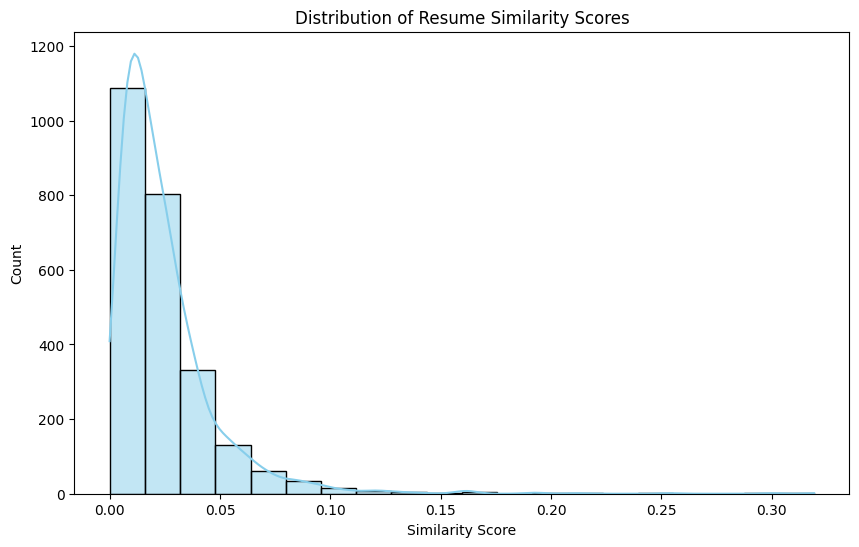

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['similarity_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Resume Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.show()

## 8. Advanced Visualizations
This section includes advanced visualizations such as Category Distribution, Word Cloud, Top Frequent Words, and Skills Analysis.

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# 1. Category Distribution
plt.figure(figsize=(15, 10))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Resume Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [ ]:
# 2. Word Cloud of Resumes
all_text = " ".join(df['cleaned_resume'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Resume Text', fontsize=16)
plt.show()

In [ ]:
# 3. Top 20 Most Frequent Words
words = all_text.split()
word_counts = Counter(words)
common_words = word_counts.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='Word', data=words_df, palette='magma')
plt.title('Top 20 Most Frequent Words in Resumes', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.show()

In [ ]:
# 4. Top 20 Most Frequent Skills
all_skills = [skill for skills in df['extracted_skills'] for skill in skills]
skill_counts = Counter(all_skills)
common_skills = skill_counts.most_common(20)
skills_df = pd.DataFrame(common_skills, columns=['Skill', 'Count'])

plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='Skill', data=skills_df, palette='coolwarm')
plt.title('Top 20 Most Frequent Technical Skills', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Skill', fontsize=14)
plt.show()

In [ ]:
# 5. Missing Skills Analysis
all_missing_skills = [skill for skills in df['missing_skills'] for skill in skills]
missing_skill_counts = Counter(all_missing_skills)
common_missing_skills = missing_skill_counts.most_common(20)
missing_skills_df = pd.DataFrame(common_missing_skills, columns=['Skill', 'Count'])

plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='Skill', data=missing_skills_df, palette='Reds_r')
plt.title('Top Missing Skills in Candidates', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Skill', fontsize=14)
plt.show()